In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import os
import seaborn as sns

from matplotlib.colors import LogNorm

In [3]:
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import pathlib
import mapclassify as mc

from shapely.geometry import Point

## Dataset

In [29]:
storm_data = pd.read_csv("../Data/Prod_datasets/Storm_events_details_full_clean.csv")

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1824\1569508335.py:1: DtypeWarning: Columns (10,20,22,23,28,29,31,33,34,36,37,42,43,46) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_data = pd.read_csv("../Data/Prod_datasets/Storm_events_details_full_clean.csv")


## FIPS coordinates

In [4]:
# FIPS_coor = pd.read_csv("../Data/US_map/US_FIPS_coordinates.csv").drop(columns = "population").rename(columns = {"lng": "long", "county_fips": "US_FIPS"})
# FIPS_coor["CZ_TYPE"] = "C"
# FIPS_coor.head()

In [4]:
## Mapping the location using the FIPS encoding

FIPS_coor = pd.read_json("../Data/US_map/fips_map.json").T.reset_index()
FIPS_coor.rename(columns = {"index": "US_FIPS"}, inplace = True)
FIPS_coor["US_FIPS"] = FIPS_coor["US_FIPS"].astype("str")
FIPS_coor["CZ_TYPE"] = "C"

## NWS Forcast zone coordinates

In [5]:
loc = gpd.read_file("../Data/US_map/NWS Forecast zone/z_05mr24.shp").drop(columns = "geometry").rename(columns = {"LON": "long", "LAT":"lat"}).drop_duplicates(subset = "STATE_ZONE")
loc["CZ_TYPE"] = "Z"

In [6]:
State_FIPS = pd.read_csv("../Data/US_map/StatesFIPSCodes.csv").drop(columns = "STATENS").rename(columns = {"STUSAB":"STATE"})

In [7]:
loc = loc.join(State_FIPS.set_index("STATE"), on = "STATE").dropna(axis = 0, subset = "STATE_FIPS")
loc.head()

,STATE,CWA,TIME_ZONE,FE_AREA,ZONE,NAME,STATE_ZONE,long,lat,SHORTNAME,CZ_TYPE,STATE_FIPS,STATE_NAME
0,AL,BMX,C,ec,019,Calhoun,AL019,-85.8261,33.7714,Calhoun,Z,1.0,Alabama
1,AL,MOB,C,sc,057,Butler,AL057,-86.6803,31.7524,Butler,Z,1.0,Alabama
2,AL,BMX,C,se,046,Bullock,AL046,-85.7161,32.1005,Bullock,Z,1.0,Alabama
3,AL,BMX,C,cc,017,Blount,AL017,-86.5674,33.9809,Blount,Z,1.0,Alabama
4,AL,BMX,C,cc,034,Bibb,AL034,-87.1264,32.9986,Bibb,Z,1.0,Alabama


## FIPS/coordinates dataset

In [8]:
loc = loc[["STATE", "STATE_FIPS", "CZ_TYPE","ZONE", "NAME", "lat", "long"]]
loc["US_FIPS"] = (loc["STATE_FIPS"] * 1000 + loc["ZONE"].astype(float)).astype("Int64").astype('str')

In [9]:
FIPS_mapping = pd.concat([loc[["CZ_TYPE","US_FIPS", "lat", "long"]], FIPS_coor[["CZ_TYPE","US_FIPS", "lat", "long"]]])

In [10]:
FIPS_mapping.dtypes

CZ_TYPE    object
US_FIPS    object
lat        object
long       object
dtype: object

## ------------

In [30]:
storm_data.shape

(1882230, 52)

In [31]:
storm_data.columns

Index(['EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS', 'YEAR', 'MONTH_NAME',
       'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME',
       'CZ_TIMEZONE', 'END_DATE_TIME', 'INJURIES_DIRECT', 'INJURIES_INDIRECT',
       'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS',
       'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY',
       'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO',
       'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME',
       'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE',
       'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT',
       'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE',
       'DAMAGE_PROPERTY_ORIGINAL', 'DAMAGE_CROPS_ORIGINAL', 'INFLATION_INDEX',
       'US_FIPS', 'lat', 'long', 'EVENT_CAT'],
      dtype='object')

In [18]:
cols = ['EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS', 'YEAR', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS','EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE',
       'DAMAGE_PROPERTY_ORIGINAL', 'DAMAGE_CROPS_ORIGINAL', 'INFLATION_INDEX']

In [14]:
mask = storm_data["EVENT_ID"].duplicated()

In [25]:
storm_data.loc[storm_data["EVENT_ID"] == 559139][cols]

,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,DAMAGE_PROPERTY,DAMAGE_CROPS,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,DAMAGE_PROPERTY_ORIGINAL,DAMAGE_CROPS_ORIGINAL,INFLATION_INDEX
1301174,92561.0,559139,NEW HAMPSHIRE,33.0,2015,0.0,0.0,An area of low pressure developed off the Delm...,"Once blizzard conditions subsided, snow and bl...",CSV,0.00K,0.00K,1.730282
1359080,92561.0,559139,NEW HAMPSHIRE,33.0,2015,0.0,0.0,An area of low pressure developed off the Delm...,"Once blizzard conditions subsided, snow and bl...",CSV,0.00K,0.00K,1.730282


<Axes: >

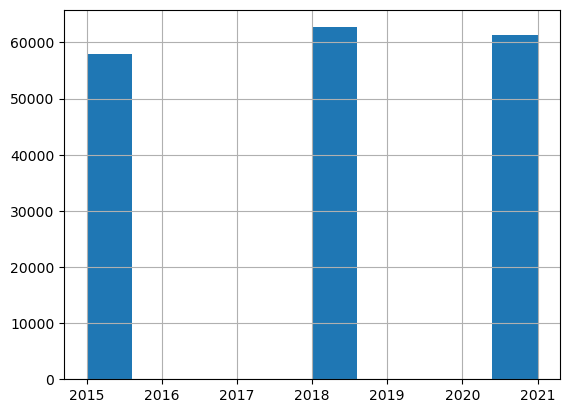

In [26]:
storm_data[mask]["YEAR"].hist()

In [11]:
storm_data.shape[0] - storm_data["EVENT_ID"].duplicated().sum()

1882231

In [13]:
storm_data["US_FIPS"] = (storm_data["STATE_FIPS"] * 1000 + storm_data["CZ_FIPS"]).astype("Int64").astype('str')
storm_data["US_FIPS"].head()

0    40149
1    48093
2    42077
3    42043
4    42039
Name: US_FIPS, dtype: object

In [14]:
# Joining the mappinf table with the storm_data dataset
storm_data = storm_data.join(FIPS_mapping[["CZ_TYPE", "US_FIPS", "lat", "long"]].set_index(["US_FIPS", "CZ_TYPE"]), on = ["US_FIPS", "CZ_TYPE"])

In [15]:
storm_data.shape

(1882230, 49)

In [16]:
def harmonize_coordinate_lat(x):
    if not np.isnan(x["BEGIN_LAT"]):
        if not np.isnan(x["END_LAT"]):
            return (x["BEGIN_LAT"] + x["END_LAT"])/2
        else:
            return x["BEGIN_LAT"]
    elif not np.isnan(x["END_LAT"]): #Redunduncy
        if not x["BEGIN_LAT"].isna():
            return (x["BEGIN_LAT"] + x["END_LAT"])/2
        else:
            return x["END_LAT"]
    else:
        return x['lat']
    

def harmonize_coordinate_long(x):
    if not np.isnan(x["BEGIN_LON"]):
        if not np.isnan(x["END_LON"]):
            return (x["BEGIN_LON"] + x["END_LON"])/2
        else:
            return x["BEGIN_LON"]
    elif not np.isnan(x["END_LON"]): #Redunduncy
        if not np.isnan(x["BEGIN_LON"]):
            return (x["BEGIN_LON"] + x["END_LON"])/2
        else:
            return x["END_LON"]
    else:
        return x['long']



# storm_data["lat_2"] = storm_data.apply(lambda x: harmonize_coordinate_lat(x), axis = 1)
# storm_data["long_2"] = storm_data.apply(harmonize_coordinate_long)

storm_data["average_lat"] = (storm_data["BEGIN_LAT"] + storm_data["END_LAT"])/2
storm_data["average_long"] = (storm_data["BEGIN_LON"] + storm_data["END_LON"])/2

storm_data["lat_fin"] = storm_data["average_lat"].where(~storm_data["average_lat"].isna(), storm_data["BEGIN_LAT"])
storm_data["long_fin"] = storm_data["average_long"].where(~storm_data["average_long"].isna(), storm_data["BEGIN_LON"])

storm_data["lat_fin"] = storm_data["lat_fin"].where(~storm_data["lat_fin"].isna(), storm_data["lat"])
storm_data["long_fin"] = storm_data["long_fin"].where(~storm_data["long_fin"].isna(), storm_data["long"])


storm_data.drop(columns=["average_lat", "average_long", "lat", "long"], inplace = True)


In [17]:
storm_data.rename(columns = {"lat_fin":'lat', "long_fin":"long"}, inplace = True)

In [18]:
storm_data[["BEGIN_LAT", "BEGIN_LON","END_LAT", "END_LON", "lat", "long"]]

,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,lat,long
0,35.1200,-99.2000,35.1700,-99.2000,35.145,-99.2
1,31.9000,-98.6000,31.7300,-98.6000,31.815,-98.6
2,40.5800,-75.7000,40.6500,-75.4700,40.615,-75.585
3,40.6000,-76.7500,NaN,NaN,40.6,-76.75
4,41.6300,-79.6800,NaN,NaN,41.63,-79.68
...,...,...,...,...,...,...
1882225,30.7200,-101.2000,30.7200,-101.2000,30.72,-101.2
1882226,32.0700,-98.9600,32.0700,-98.9600,32.07,-98.96
1882227,34.4000,-86.0000,34.4000,-86.0000,34.4,-86.0
1882228,34.4864,-87.6869,34.4864,-87.6869,34.4864,-87.6869


In [25]:
(storm_data["lat"].isna()) | (storm_data["long"].isna())

0          False
1          False
2          False
3          False
4          False
           ...  
1882225    False
1882226    False
1882227    False
1882228    False
1882229    False
Length: 1882230, dtype: bool

In [26]:
no_coordinates = storm_data.loc[(storm_data["lat"].isna())| (storm_data["long"].isna())]

In [33]:
no_coordinates["BEGIN_DATE_TIME"].value_counts()

BEGIN_DATE_TIME
2013-01-01 00:00:00    74
2012-07-01 00:00:00    73
2011-09-01 00:00:00    71
2012-12-01 00:00:00    68
2012-08-01 00:00:00    63
                       ..
2006-07-04 15:36:00     1
2006-05-25 17:05:00     1
2006-05-25 18:01:00     1
2006-06-21 07:30:00     1
2024-02-26 01:14:00     1
Name: count, Length: 41356, dtype: int64

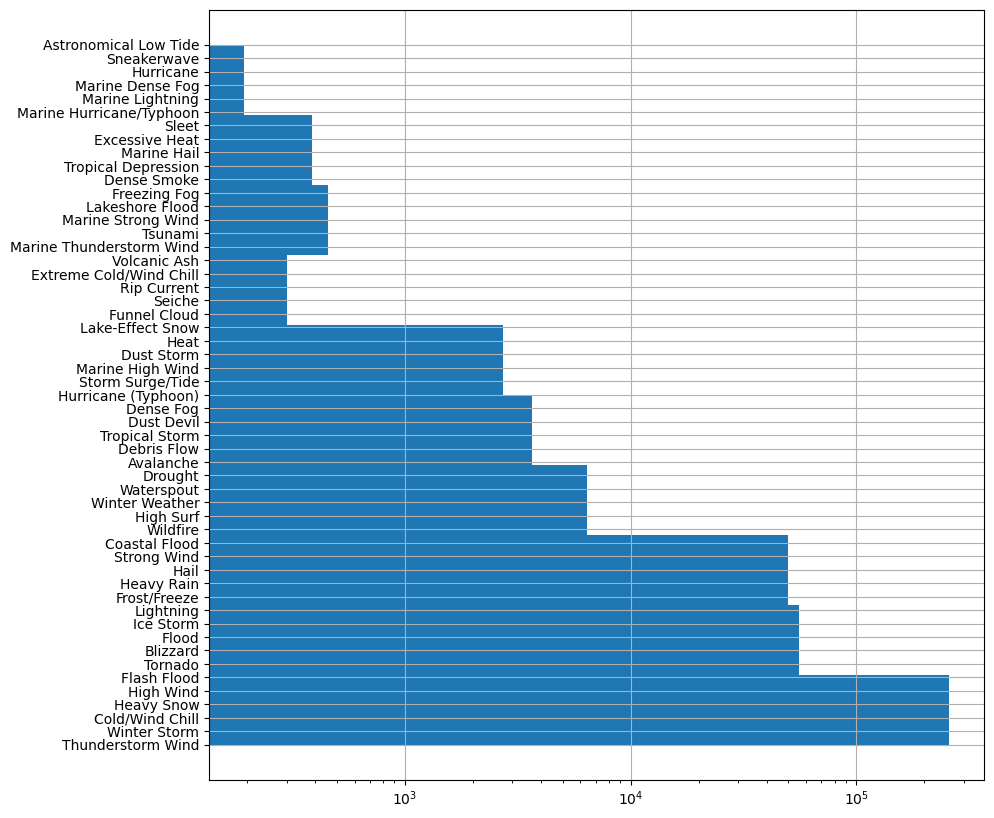

In [54]:
plt.figure(figsize = (10,10))
storm_data.loc[(storm_data['DAMAGE_PROPERTY'] > 0) & (storm_data["YEAR"] > 1995)]["EVENT_TYPE"].hist(orientation='horizontal')
plt.xscale('log');


In [42]:
no_coordinates["DAMAGE_PROPERTY"].describe()

count    7.670400e+04
mean     1.498851e+06
std      8.383052e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.790000e+10
Name: DAMAGE_PROPERTY, dtype: float64

In [38]:
storm_data.columns

Index(['EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS', 'YEAR', 'MONTH_NAME',
       'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME',
       'CZ_TIMEZONE', 'END_DATE_TIME', 'INJURIES_DIRECT', 'INJURIES_INDIRECT',
       'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS',
       'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY',
       'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO',
       'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME',
       'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE',
       'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT',
       'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE',
       'inflation_index', 'US_FIPS', 'lat', 'long'],
      dtype='object')

In [ ]:
# Localisation of the events

begin_points = storm_data.apply(
    lambda srs: Point(float(srs['long']), float(srs['lat'])),
    axis='columns'
)
begin_points

0           POINT (-98.991436 35.289497)
1           POINT (-98.549617 31.951645)
2           POINT (-75.590627 40.614241)
3           POINT (-76.792634 40.412565)
4           POINT (-80.107795 41.687876)
                       ...              
1882225    POINT (-101.404211 30.717532)
1882226     POINT (-98.998456 31.764137)
1882227     POINT (-85.803992 34.460929)
1882228     POINT (-87.842814 34.441989)
1882229                      POINT EMPTY
Length: 1882230, dtype: object

In [10]:
# Aumenting the dataset with the location of the events

storm_data_geocoded = gpd.GeoDataFrame(storm_data[['EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS', 'YEAR', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME','BEGIN_DATE_TIME','CZ_TIMEZONE', 'END_DATE_TIME', 'INJURIES_DIRECT', 'INJURIES_INDIRECT',
       'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS',
       'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY','BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE',
       'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT',
       'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE',
       'inflation_index', "lat", "long"]], geometry=begin_points)
# test = storm_data_geocoded.loc[(storm_data_geocoded["BEGIN_LAT"] == storm_data_geocoded["BEGIN_LAT"]) & (storm_data_geocoded["BEGIN_LON"] == storm_data_geocoded["BEGIN_LON"])]

storm_data_geocoded = storm_data_geocoded.loc[(storm_data_geocoded["lat"] == storm_data_geocoded["lat"]) & (storm_data_geocoded["long"] == storm_data_geocoded["long"])]

In [364]:
test = storm_data.loc[(storm_data["lat_2"].isnull()) & (storm_data["YEAR"]>1995)][["STATE","CZ_NAME","CZ_TYPE", "STATE_FIPS", "CZ_FIPS","US_FIPS",'BEGIN_LAT', 'BEGIN_LON', 'END_LAT',
       'END_LON', "lat", "long", "YEAR"]]

In [365]:
test

,STATE,CZ_NAME,CZ_TYPE,STATE_FIPS,CZ_FIPS,US_FIPS,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,lat,long,YEAR
232249,CALIFORNIA,COASTAL MONTEREY COUNTY,Z,6.0,9,6009,NaN,NaN,NaN,NaN,NaN,NaN,1996
232262,WYOMING,NORTH CARBON,Z,56.0,62,56062,NaN,NaN,NaN,NaN,NaN,NaN,1996
232276,VIRGINIA,HANOVER,Z,51.0,63,51063,NaN,NaN,NaN,NaN,NaN,NaN,1996
232283,WYOMING,CHEYENNE FOOTHILLS,Z,56.0,69,56069,NaN,NaN,NaN,NaN,NaN,NaN,1996
232301,WYOMING,CHEYENNE FOOTHILLS,Z,56.0,69,56069,NaN,NaN,NaN,NaN,NaN,NaN,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879623,VIRGIN ISLANDS,ST. THOMAS / ST. JOHN AND ADJACENT ISLANDS,Z,96.0,1,96001,NaN,NaN,NaN,NaN,NaN,NaN,2024
1880138,PUERTO RICO,NORTHWEST,Z,99.0,8,99008,NaN,NaN,NaN,NaN,NaN,NaN,2024
1881207,OREGON,NORTHERN OREGON COAST,Z,41.0,1,41001,NaN,NaN,NaN,NaN,NaN,NaN,2024
1881212,GUAM,GUAM,Z,98.0,6,98006,NaN,NaN,NaN,NaN,NaN,NaN,2024


In [366]:
test.loc[test["CZ_TYPE"] == "C"]

,STATE,CZ_NAME,CZ_TYPE,STATE_FIPS,CZ_FIPS,US_FIPS,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,lat,long,YEAR
239093,PUERTO RICO,FAJARDO RIO GRANDE,C,99.0,17,99017,NaN,NaN,NaN,NaN,NaN,NaN,1996
239162,PUERTO RICO,CAROLINA,C,99.0,11,99011,NaN,NaN,NaN,NaN,NaN,NaN,1996
241589,ALASKA,CK INLT SUSITNA(C) / HOMER(C),C,2.0,18,2018,NaN,NaN,NaN,NaN,NaN,NaN,1996
241590,ALASKA,CK INLT SUSITNA(C) / HOMER(C),C,2.0,18,2018,NaN,NaN,NaN,NaN,NaN,NaN,1996
242432,PUERTO RICO,CAGUAS LAS PIEDRAS,C,99.0,7,99007,NaN,NaN,NaN,NaN,NaN,NaN,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
776509,PUERTO RICO,SAN JUAN AND VICINITY,C,99.0,1,99001,NaN,NaN,NaN,NaN,NaN,NaN,2006
777097,AMERICAN SAMOA,TUTUILA,C,97.0,2,97002,NaN,NaN,NaN,NaN,NaN,NaN,2006
777098,AMERICAN SAMOA,MANU'A,C,97.0,3,97003,NaN,NaN,NaN,NaN,NaN,NaN,2006
777099,AMERICAN SAMOA,TUTUILA,C,97.0,2,97002,NaN,NaN,NaN,NaN,NaN,NaN,2006


In [40]:
test = pd.read_csv("../Data/Prod_datasets/Storm_events_details_full_clean_bis.csv")

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_18808\609434646.py:1: DtypeWarning: Columns (10,20,22,23,28,29,31,33,34,36,37,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("../Data/Prod_datasets/Storm_events_details_full_clean_bis.csv")


In [41]:
test[['EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS', 'YEAR', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME','BEGIN_DATE_TIME','CZ_TIMEZONE', 'END_DATE_TIME', 'INJURIES_DIRECT', 'INJURIES_INDIRECT',
       'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS',
       'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY','BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE',
       'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT',
       'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE',
       'inflation_index', "lat", "long"]]

,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,BEGIN_DATE_TIME,...,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,inflation_index,lat,long
0,NaN,10096222,OKLAHOMA,40.0,1950,Tornado,C,149,WASHITA,2050-04-28 14:45:00,...,35.1200,-99.2000,35.1700,-99.2000,NaN,NaN,PUB,12.051658,35.1450,-99.2000
1,NaN,10120412,TEXAS,48.0,1950,Tornado,C,93,COMANCHE,2050-04-29 15:30:00,...,31.9000,-98.6000,31.7300,-98.6000,NaN,NaN,PUB,12.051658,31.8150,-98.6000
2,NaN,10104927,PENNSYLVANIA,42.0,1950,Tornado,C,77,LEHIGH,2050-07-05 18:00:00,...,40.5800,-75.7000,40.6500,-75.4700,NaN,NaN,PUB,12.051658,40.6150,-75.5850
3,NaN,10104928,PENNSYLVANIA,42.0,1950,Tornado,C,43,DAUPHIN,2050-07-05 18:30:00,...,40.6000,-76.7500,NaN,NaN,NaN,NaN,PUB,12.051658,40.6000,-76.7500
4,NaN,10104929,PENNSYLVANIA,42.0,1950,Tornado,C,39,CRAWFORD,2050-07-24 14:40:00,...,41.6300,-79.6800,NaN,NaN,NaN,NaN,PUB,12.051658,41.6300,-79.6800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882225,189154.0,1163212,TEXAS,48.0,2024,Hail,C,105,CROCKETT,2024-02-11 00:40:00,...,30.7200,-101.2000,30.7200,-101.2000,Scattered thunderstorms developed across much ...,Public reported golf ball size hail in Ozona. ...,CSV,1.000000,30.7200,-101.2000
1882226,189154.0,1163214,TEXAS,48.0,2024,Hail,C,49,BROWN,2024-02-11 02:15:00,...,32.0700,-98.9600,32.0700,-98.9600,Scattered thunderstorms developed across much ...,"Public reported half dollar size hail. Also, p...",CSV,1.000000,32.0700,-98.9600
1882227,187597.0,1162451,ALABAMA,1.0,2024,Thunderstorm Wind,C,49,DEKALB,2024-02-12 16:38:00,...,34.4000,-86.0000,34.4000,-86.0000,As a low pressure lifted northeast through the...,The roof was lifted and displaced on a buildin...,CSV,1.000000,34.4000,-86.0000
1882228,187597.0,1162453,ALABAMA,1.0,2024,Hail,C,59,FRANKLIN,2024-02-12 12:19:00,...,34.4864,-87.6869,34.4864,-87.6869,As a low pressure lifted northeast through the...,An unusually shaped hail stone fell in Russell...,CSV,1.000000,34.4864,-87.6869


In [42]:
test = test.loc[(test["lat"] == test["lat"]) & (test["long"] == test["long"])]

In [45]:
test[test["EVENT_TYPE"] == "Hurricane"]

,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,...,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,inflation_index,US_FIPS,lat,long
1414350,110795.0,664314,GEORGIA,13.0,2016,October,Hurricane,Z,119,COASTAL CHATHAM,...,NaN,NaN,NaN,Matthew first developed into a Tropical Storm ...,A Hurricane Matthew NWS survey of Tybee Island...,CSV,1.690224,13119.0,31.9181,-81.0342
1414352,110795.0,666603,GEORGIA,13.0,2016,October,Hurricane,Z,119,COASTAL CHATHAM,...,NaN,NaN,NaN,Matthew first developed into a Tropical Storm ...,The media reported a large tree on a home near...,CSV,1.690224,13119.0,31.9181,-81.0342
1414353,110795.0,666604,GEORGIA,13.0,2016,October,Hurricane,Z,119,COASTAL CHATHAM,...,NaN,NaN,NaN,Matthew first developed into a Tropical Storm ...,A trained spotter reported a large tree was up...,CSV,1.690224,13119.0,31.9181,-81.0342
1414355,110795.0,664274,GEORGIA,13.0,2016,October,Hurricane,Z,119,COASTAL CHATHAM,...,NaN,NaN,NaN,Matthew first developed into a Tropical Storm ...,A report via Twitter indicated numerous trees ...,CSV,1.690224,13119.0,31.9181,-81.0342
1414372,110795.0,664248,GEORGIA,13.0,2016,October,Hurricane,Z,119,COASTAL CHATHAM,...,NaN,NaN,NaN,Matthew first developed into a Tropical Storm ...,A trained spotter reported a large tree down n...,CSV,1.690224,13119.0,31.9181,-81.0342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846411,184689.0,1131853,FLORIDA,12.0,2023,August,Hurricane,Z,19,MADISON,...,NaN,NaN,NaN,Hurricane Idalia made landfall on the morning ...,"Approximately 11,467 residents, or nearly 100%...",CSV,1.029998,12019.0,30.4442,-83.4700
1846412,184690.0,1131871,GEORGIA,13.0,2023,August,Hurricane,Z,160,LOWNDES,...,NaN,NaN,NaN,Hurricane Idalia made landfall on the morning ...,"There were 1,127 homes damaged, with 684 being...",CSV,1.029998,13160.0,30.8339,-83.2677
1846413,184690.0,1131872,GEORGIA,13.0,2023,August,Hurricane,Z,161,LANIER,...,NaN,NaN,NaN,Hurricane Idalia made landfall on the morning ...,"Approximately 1333 residents, or 76% lost powe...",CSV,1.029998,13161.0,31.0380,-83.0626
1846414,184690.0,1131870,GEORGIA,13.0,2023,August,Hurricane,Z,159,BROOKS,...,NaN,NaN,NaN,Hurricane Idalia made landfall on the morning ...,"Approximately 863 residents, or 92% lost power...",CSV,1.029998,13159.0,30.8420,-83.5803
